### Load Data

In [1]:
import numpy as np
import pandas as pd 
import os
import seaborn as sns

In [2]:
## Reading the dataset
path = '../DSfinalProject/data'
os.listdir(path)
sales_data = pd.read_csv(path+'/sales_train.csv')
item_cat = pd.read_csv(path+'/item_categories.csv')
items = pd.read_csv(path+'/items.csv')
shops = pd.read_csv(path+'/shops.csv')
sample_submission = pd.read_csv(path+'/sample_submission.csv')
test = pd.read_csv(path+'/test.csv')

### Data Description
- ID - an Id that represents a (Shop, Item) tuple within the test set;

- shop_id - unique identifier of a shop;

- item_id - unique identifier of a product;

- item_category_id - unique identifier of item category;

- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure;

- item_price - current price of an item;

- date - date in format dd/mm/yyyy;

- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33;

- item_name - name of item;

- shop_name - name of shop;

- item_category_name - name of item category.

In [3]:
print("lines in train set:",sales_data.shape)
print("items num in train:",sales_data['item_id'].nunique())
print("shops num in train:",sales_data['shop_id'].nunique())
print("lines in test set:",test.shape)
print("items num in test:",test['item_id'].nunique())
print("shops num in test:",test['shop_id'].nunique())

lines in train set: (2935849, 6)
items num in train: 21807
shops num in train: 60
lines in test set: (214200, 3)
items num in test: 5100
shops num in test: 42


### Baseline Model

In [4]:
#aggregate data 33 month
train_tmp = sales_data[sales_data['date_block_num']==33]
grouped = sales_data[['shop_id','item_id','item_cnt_day']].groupby(['shop_id','item_id']).agg({'item_cnt_day':'sum'}).reset_index()
grouped = grouped.rename(columns={'item_cnt_day':'item_cnt_month'})

In [5]:
test_grouped = pd.merge(test,grouped,on=['shop_id','item_id'],how = 'left')
test_grouped['item_cnt_month'] = test_grouped['item_cnt_month'].fillna(0).clip(0,20)
test_grouped = test_grouped[['ID','item_cnt_month']]
submission = test_grouped.set_index('ID')
submission.to_csv('baseline.csv')

### TotalTrend

In [6]:
#total sales per month  (by summing the item counts per day)
sales_data_month = sales_data.groupby('date_block_num',as_index=False)['item_cnt_day'].sum()
sales_data_month.head()

,date_block_num,item_cnt_day
0,0,131479.0
1,1,128090.0
2,2,147142.0
3,3,107190.0
4,4,106970.0


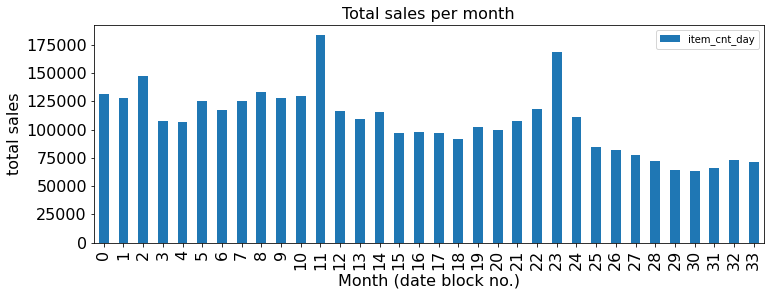

In [7]:
#visualize the total sales pattern per month
import matplotlib.pyplot as plt
sales_data_month.plot.bar(x='date_block_num', y = 'item_cnt_day', figsize=(12,4));
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Month (date block no.)', fontsize = 16)
plt.ylabel('total sales', fontsize = 16)
plt.title("Total sales per month", fontsize = 16);

### Each shops

In [8]:
###each shop is new or outdated?
sales_shop_piv = sales_data.pivot_table(index=['shop_id'],values=['item_cnt_day'],
                                       columns='date_block_num',aggfunc=np.sum,fill_value=0).reset_index()
sales_shop_piv.columns = sales_shop_piv.columns.droplevel().map(str)
sales_shop_piv = sales_shop_piv.reset_index(drop=True).rename_axis(None,axis=1)
sales_shop_piv.columns.values[0] = 'shop_id'

In [9]:
for i in range(27,34):
    print('Not exist in month',i,sales_shop_piv['shop_id'][sales_shop_piv.loc[:,'0':str(i)].sum(axis=1)==0].unique())
for i in range(27,34):
    print('shop outdated for month',i,sales_shop_piv['shop_id'][sales_shop_piv.loc[:,str(i):].sum(axis=1)==0].unique())

Not exist in month 27 [36]
Not exist in month 28 [36]
Not exist in month 29 [36]
Not exist in month 30 [36]
Not exist in month 31 [36]
Not exist in month 32 [36]
Not exist in month 33 []
shop outdated for month 27 [ 0  1  8 11 13 17 23 30 32 40 43]
shop outdated for month 28 [ 0  1  8 11 13 17 23 30 32 33 40 43 54]
shop outdated for month 29 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
shop outdated for month 30 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
shop outdated for month 31 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
shop outdated for month 32 [ 0  1  8 11 13 17 23 29 30 32 33 40 43 54]
shop outdated for month 33 [ 0  1  8 11 13 17 23 27 29 30 32 33 40 43 51 54]


#### Shop features

In [10]:
shops['shop_name'].head()

0     !Якутск Орджоникидзе, 56 фран
1     !Якутск ТЦ "Центральный" фран
2                  Адыгея ТЦ "Мега"
3    Балашиха ТРК "Октябрь-Киномир"
4          Волжский ТЦ "Волга Молл"
Name: shop_name, dtype: object

In [11]:
sales_data.loc[sales_data['shop_id']==0, 'shop_id'] = 57
sales_data.loc[sales_data['shop_id']==1, 'shop_id'] = 58
sales_data.loc[sales_data['shop_id']==11, 'shop_id'] = 10
sales_data.loc[sales_data['shop_id']==40, 'shop_id'] = 39

In [12]:
shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]','').str.replace('\d+','').str.strip()
shops['shop_city'] = shops['shop_name'].str.partition(' ')[0]
shops['shop_type'] = shops['shop_name'].apply(lambda x: 'мтрц'if 'мтрц'in x else 'трц'if 'трц'in x else 'трк'if 'трк'in x else 'тц'if 'тц'in x else 'тк'if 'тк'in x else 'NO_DATA' )

C:\Users\yuanhsu\AppData\Local\Temp\ipykernel_15540\1230155204.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  shops['shop_name'] = shops['shop_name'].apply(lambda x: x.lower()).str.replace('[^\w\s]','').str.replace('\d+','').str.strip()


In [13]:
from sklearn.preprocessing import LabelEncoder
shops['shop_city_code'] = LabelEncoder().fit_transform(shops['shop_city'])
shops['shop_type_code'] = LabelEncoder().fit_transform(shops['shop_type'])
shops.head()

,shop_name,shop_id,shop_city,shop_type,shop_city_code,shop_type_code
0,якутск орджоникидзе фран,0,якутск,NO_DATA,29,0
1,якутск тц центральный фран,1,якутск,тц,29,5
2,адыгея тц мега,2,адыгея,тц,0,5
3,балашиха трк октябрькиномир,3,балашиха,трк,1,3
4,волжский тц волга молл,4,волжский,тц,2,5


### Each item category

Text(0, 0.5, 'value_counts')

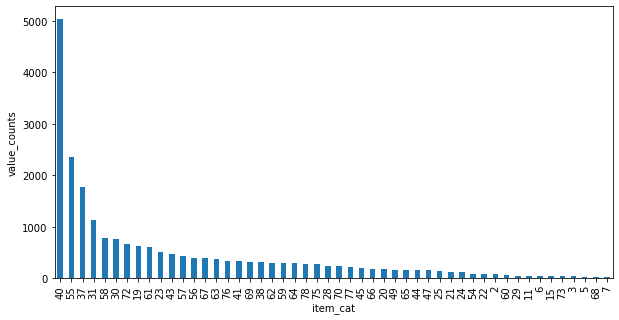

In [14]:
#largest number of "item_name" is item_id = 40
fig, ax = plt.subplots(figsize=(10,5))
items.item_category_id.value_counts().iloc[:50].plot.bar(ax=ax)
plt.xlabel('item_cat')
plt.ylabel('value_counts')

In [15]:
sales_data_piv = sales_data.pivot_table(index=['item_id'],values=['item_cnt_day'],
                                       columns='date_block_num',aggfunc=np.sum,fill_value=0).reset_index()
sales_data_piv.columns = sales_data_piv.columns.droplevel().map(str)
sales_data_piv = sales_data_piv.reset_index(drop=True).rename_axis(None,axis=1)
sales_data_piv.columns.values[0] = 'item_id'

In [16]:
#see how many items dont have sales in recent 6 months
sales_data_piv

,item_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21802,22165,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
21803,22166,0,0,0,0,0,0,0,0,0,...,7,8,12,4,8,10,8,11,5,11
21804,22167,0,0,0,0,0,0,0,0,56,...,33,46,40,38,31,33,34,29,21,37
21805,22168,2,2,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
outdated = sales_data_piv[sales_data_piv.loc[:,'27':].sum(axis=1)==0]
print("outdated items:",len(outdated))
print("outdated items in test set:",test[test['item_id'].isin(outdated['item_id'])]['item_id'].nunique())

outdated items: 12391
outdated items in test set: 164


In [18]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


#### item category feature

In [19]:
item_cat

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [20]:
#clean data to the same format
line1 = [26,27,28,30,31]
line2 = [81,82]
for idx in line1:
    name = item_cat.loc[idx,'item_category_name']
    name = name.replace('Игры','Игры -')
    item_cat.loc[idx,'item_category_name'] = name
for idx in line2:
    name = item_cat.loc[idx,'item_category_name']
    name = name.replace('Чистые','Чистые -')
    item_cat.loc[idx,'item_category_name'] = name
name = item_cat.loc[32,'item_category_name']
name = name.replace('Карты оплаты','Карты оплаты -')
item_cat.loc[32,'item_category_name'] = name

In [21]:
item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x:x[0].strip())
item_cat['subtype'] = item_cat['split'].map(lambda x:x[1].strip() if len(x)>1 else x[0].strip())
item_cat = item_cat[['item_category_name','type','subtype','item_category_id']]
item_cat.head()

,item_category_name,type,subtype,item_category_id
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники,0
1,Аксессуары - PS2,Аксессуары,PS2,1
2,Аксессуары - PS3,Аксессуары,PS3,2
3,Аксессуары - PS4,Аксессуары,PS4,3
4,Аксессуары - PSP,Аксессуары,PSP,4


In [22]:
item_cat['cat_type_code'] = LabelEncoder().fit_transform(item_cat['type'])
item_cat['cat_subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat.head()

,item_category_name,type,subtype,item_category_id,cat_type_code,cat_subtype_code
0,PC - Гарнитуры/Наушники,PC,Гарнитуры/Наушники,0,0,33
1,Аксессуары - PS2,Аксессуары,PS2,1,1,13
2,Аксессуары - PS3,Аксессуары,PS3,2,1,14
3,Аксессуары - PS4,Аксессуары,PS4,3,1,15
4,Аксессуары - PSP,Аксессуары,PSP,4,1,17


### Sales and Price outlier

Sale volume outliers: [2169.]


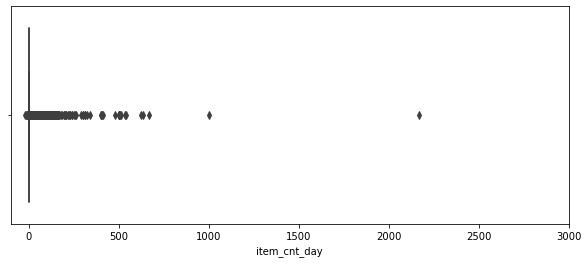

In [23]:
import matplotlib.pyplot as plt
#get outlier
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=sales_data['item_cnt_day'])
print("Sale volume outliers:",sales_data['item_cnt_day'][sales_data['item_cnt_day']>1001].unique())

Sale price outliers: [307980.]


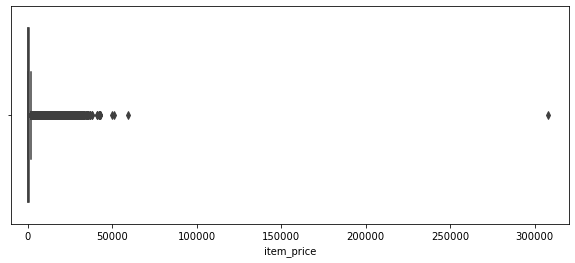

In [24]:
plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x=sales_data['item_price'])
print("Sale price outliers:",sales_data['item_price'][sales_data['item_price']>300000].unique())

In [25]:
#delete outlier
sales_data = sales_data[sales_data['item_cnt_day']<1001]
sales_data = sales_data[sales_data['item_price']<300000]

### Price negative >> median

In [26]:
sales_data[sales_data['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [27]:
median = sales_data[(sales_data['date_block_num']==4)&(sales_data['shop_id']==32)
                    &(sales_data['item_id']==2973)&(sales_data['item_price']>0)].item_price.median()
sales_data.loc[sales_data['item_price']<0,'item_price']=median

In [28]:
sales_data = sales_data[(sales_data["item_cnt_day"] > 0)]

In [29]:
#total income calculation
sales_data.loc['sales_income'] = sales_data['item_price'] * sales_data['item_cnt_day']
sales_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0.0,59.0,22154.0,999.00,1.0
1,03.01.2013,0.0,25.0,2552.0,899.00,1.0
3,06.01.2013,0.0,25.0,2554.0,1709.05,1.0
4,15.01.2013,0.0,25.0,2555.0,1099.00,1.0
5,10.01.2013,0.0,25.0,2564.0,349.00,1.0


In [31]:
# #total sales per month (considering the item price)
# monthly_sales_price = sales_data.groupby(['date_block_num'],as_index=False)['sales_income'].sum()
# monthly_sales_price.head()

In [33]:
# ## visualize the total sales to see the pattern per month
# import matplotlib.pyplot as plt
# monthly_sales_price.plot.bar(x='date_block_num', y = 'sales_income', figsize=(12,4));
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlabel('Month (date block no.)', fontsize = 16)
# plt.ylabel('total sales', fontsize = 16)
# plt.title("Total sales ($) per month", fontsize = 16);

### Test Data Analysis

In [ ]:
test_sales = test.merge(sales_data,on=['item_id','shop_id'],how='left').dropna()
pairs = test[test['ID'].isin(test_sales['ID'])]
no_data = test[~(test['item_id'].isin(sales_data['item_id']))]
print('pairs:',len(pairs),'percentage:',len(pairs)/214200)
print('no data item:',len(no_data),'percentage:',len(no_data)/214200)
print('onlyo item_id info:',len(test)-len(pairs)-len(no_data),'percentage:',1-len(pairs)/214200-len(no_data)/214200)

### Merge Dataset

In [34]:
sales_data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0.0,59.0,22154.0,999.00,1.0
1,03.01.2013,0.0,25.0,2552.0,899.00,1.0
3,06.01.2013,0.0,25.0,2554.0,1709.05,1.0
4,15.01.2013,0.0,25.0,2555.0,1099.00,1.0
5,10.01.2013,0.0,25.0,2564.0,349.00,1.0
...,...,...,...,...,...,...
2935845,09.10.2015,33.0,25.0,7460.0,299.00,1.0
2935846,14.10.2015,33.0,25.0,7459.0,349.00,1.0
2935847,22.10.2015,33.0,25.0,7440.0,299.00,1.0
2935848,03.10.2015,33.0,25.0,7460.0,299.00,1.0


In [35]:
# #train_new = train_new.merge(groupby,on=['item_id','shop_id','date_block_num'],how='left')
# #items+items_category
item_merge = items.merge(item_cat,on=['item_category_id'],how='left')
# #shops+sales_data
shops_sales = sales_data.merge(shops,on=['shop_id'],how='left')
# #merge above two df
train_prep = shops_sales.merge(item_merge,on=['item_id'],how='left')

In [37]:
# #represent month in date field as its first day
# train_prep['date'] = pd.to_datetime(train_prep['date'],format = '%d.%m.%Y')
# train_prep['date'] = train_prep['date'].dt.year.astype('str') + '-' + train_prep['date'].dt.month.astype('str') + '-01'
# train_prep['date'] = pd.to_datetime(train_prep['date'])

In [38]:
group_train = train_prep.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})
# groupby = sales_data.groupby(['item_id','shop_id','date_block_num']).agg({'item_cnt_day':'sum'})

In [39]:
group_train.groupby(['item_id','shop_id']).size().reset_index()

,item_id,shop_id,0
0,0.0,54.0,1
1,1.0,55.0,5
2,2.0,54.0,2
3,3.0,54.0,2
4,4.0,54.0,1
...,...,...,...
418194,22168.0,12.0,2
418195,22168.0,16.0,1
418196,22168.0,42.0,1
418197,22168.0,43.0,1


In [40]:
group_train_piv = group_train.pivot_table(index=['item_id','shop_id'], columns = 'date_block_num', values = 'item_cnt_day', fill_value = 0).reset_index()

In [41]:
group_train_piv

date_block_num,item_id,shop_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0.0,54.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,55.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.0,54.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.0,54.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.0,54.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418194,22168.0,12.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
418195,22168.0,16.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
418196,22168.0,42.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
418197,22168.0,43.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### EWMA

In [42]:
ewma = group_train_piv.loc[:,0:].ewm(span=34,axis=1).mean()
ewma.columns = ['ewm'+str(col) for col in ewma.columns]

In [43]:
ewma

,ewm0.0,ewm1.0,ewm2.0,ewm3.0,ewm4.0,ewm5.0,ewm6.0,ewm7.0,ewm8.0,ewm9.0,...,ewm24.0,ewm25.0,ewm26.0,ewm27.0,ewm28.0,ewm29.0,ewm30.0,ewm31.0,ewm32.0,ewm33.0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058625,0.054349,0.050446,0.046876,0.043604,0.040597,0.037831,0.035282,0.032928,0.030752
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.315560,0.292543,0.271537,0.252321,0.234705,0.218524,0.203634,0.189910,0.177240,0.165528
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.121221,0.112379,0.104310,0.096928,0.090161,0.083945,0.078225,0.072953,0.068086,0.063587
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.107391,0.099558,0.092409,0.085870,0.079875,0.074368,0.069301,0.064630,0.060318,0.056332
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.058625,0.054349,0.050446,0.046876,0.043604,0.040597,0.037831,0.035282,0.032928,0.030752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418194,1.0,0.485294,0.313923,0.228386,0.177182,0.143144,0.118915,0.100816,0.225791,0.196783,...,0.047007,0.043579,0.040449,0.037587,0.034963,0.032552,0.030334,0.028290,0.026403,0.024658
418195,0.0,0.514706,0.332949,0.242228,0.187920,0.151819,0.126122,0.106926,0.092065,0.080237,...,0.019167,0.017769,0.016493,0.015326,0.014256,0.013273,0.012369,0.011535,0.010766,0.010054
418196,0.0,0.514706,0.332949,0.242228,0.187920,0.151819,0.126122,0.106926,0.092065,0.080237,...,0.019167,0.017769,0.016493,0.015326,0.014256,0.013273,0.012369,0.011535,0.010766,0.010054
418197,0.0,0.000000,0.353128,0.256908,0.199309,0.161021,0.133766,0.113407,0.097645,0.085100,...,0.020329,0.018846,0.017493,0.016255,0.015120,0.014077,0.013118,0.012234,0.011418,0.010663


In [53]:
# group_train_piv_ewma = pd.concat([group_train_piv_original,ewma],axis=1)
# test_ewma = pd.merge(test, group_train_piv_ewma,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# # filling the empty values found in the dataset
# test_ewma.fillna(0, inplace = True)
# test_ewma

In [51]:
# ls_col = []
# for i in group_train_piv_original.columns:
#     if i != 'item_id' and i !='shop_id':
#         ls_col.append(i)

In [52]:
# ## ewma
# group_ewma = group_train_piv_ewma.drop(ls_col, axis = 1)

In [54]:
# test_ewma = pd.merge(test, group_ewma,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# # filling the empty values found in the dataset
# test_ewma.fillna(0, inplace = True)
# test_ewma
# # test_data = test_data.drop_duplicates()

In [48]:
test_merge = pd.merge(test, group_train_piv,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# filling the empty values found in the dataset
test_merge.fillna(0, inplace = True)
test_merge
# test_data = test_data.drop_duplicates()

,ID,shop_id,item_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Original Data

In [50]:
# group_train_piv_original = group_train_piv.drop(['6_month_avg', '6_month_std'], axis = 1)

In [57]:
test_original = pd.merge(test, group_train_piv,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# filling the empty values found in the dataset
test_original.fillna(0, inplace = True)
test_original

,ID,shop_id,item_id,0.0,1.0,2.0,3.0,4.0,5.0,6.0,...,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,32.0,33.0
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214196,214196,45,16188,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214197,214197,45,15757,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
214198,214198,45,19648,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Other Features

In [ ]:
group_train_piv['6_month_avg'] = group_train_piv.loc[:,28:].mean(axis=1)
group_train_piv['6_month_std'] = group_train_piv.loc[:,28:].std(axis=1)

In [ ]:
test_of = pd.merge(test, group_train_piv,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# filling the empty values found in the dataset
test_of.fillna(0, inplace = True)
test_of
# test_data = test_data.drop_duplicates()

In [ ]:
group_train_of_ewma = pd.concat([group_train_piv,ewma],axis=1)
test_of_ewma = pd.merge(test, group_train_of_ewma,  how='left', left_on=['item_id','shop_id'], right_on = ['item_id','shop_id'])
# filling the empty values found in the dataset
test_of_ewma.fillna(0, inplace = True)
test_of_ewma

In [ ]:
group_train_piv

# 1 years data

In [55]:
original_24 = group_train_piv.loc[:,10:]

In [77]:
test_24 = test_original.loc[:,11:]

### XGBOOST

In [94]:
dataset = group_train_piv.loc[:,0:]
data_test = test_original.loc[:,1:]

In [96]:
from sklearn.model_selection import train_test_split
x_train, val_x, y_train, val_y = train_test_split(dataset.values[:,:-1], dataset.values[:,-1:], test_size=0.2, random_state=42)

In [62]:
from xgboost import XGBRegressor

In [97]:
#设定模型参数
model = XGBRegressor(n_estimators=3000,
                     max_depth=10,
                     colsample_bytree=0.5, 
                     subsample=0.5, 
                     learning_rate = 0.001
                    )

In [98]:
#进行模型训练，并设置早停函数(建议在kaggle端进行)
model.fit(x_train, y_train, 
          eval_metric="logloss", 
          eval_set=[(x_train, y_train), (val_x, val_y)], 
          verbose=True, 
          early_stopping_rounds = 50)

[0]	validation_0-logloss:0.68191	validation_1-logloss:0.69041


C:\Users\yuanhsu\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\yuanhsu\anaconda3\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-logloss:0.53032	validation_1-logloss:0.68875
[2]	validation_0-logloss:0.51436	validation_1-logloss:0.68654
[3]	validation_0-logloss:0.47011	validation_1-logloss:0.68339
[4]	validation_0-logloss:0.43774	validation_1-logloss:0.58362
[5]	validation_0-logloss:0.39920	validation_1-logloss:0.58061
[6]	validation_0-logloss:0.38613	validation_1-logloss:0.57383
[7]	validation_0-logloss:0.34963	validation_1-logloss:0.49398
[8]	validation_0-logloss:0.31994	validation_1-logloss:0.49177
[9]	validation_0-logloss:0.28286	validation_1-logloss:0.48919
[10]	validation_0-logloss:0.28006	validation_1-logloss:0.47064
[11]	validation_0-logloss:0.26647	validation_1-logloss:0.46930
[12]	validation_0-logloss:0.25795	validation_1-logloss:0.45404
[13]	validation_0-logloss:0.25600	validation_1-logloss:0.42772
[14]	validation_0-logloss:0.25385	validation_1-logloss:0.42631
[15]	validation_0-logloss:0.24473	validation_1-logloss:0.42490
[16]	validation_0-logloss:0.23955	validation_1-logloss:0.42337
[

[130]	validation_0-logloss:-0.27001	validation_1-logloss:0.09438
[131]	validation_0-logloss:-0.27138	validation_1-logloss:0.09373
[132]	validation_0-logloss:-0.27428	validation_1-logloss:0.09274
[133]	validation_0-logloss:-0.27633	validation_1-logloss:0.09179
[134]	validation_0-logloss:-0.27790	validation_1-logloss:0.09039
[135]	validation_0-logloss:-0.28043	validation_1-logloss:0.08962
[136]	validation_0-logloss:-0.28240	validation_1-logloss:0.08831
[137]	validation_0-logloss:-0.28366	validation_1-logloss:0.08290
[138]	validation_0-logloss:-0.28700	validation_1-logloss:0.07778
[139]	validation_0-logloss:-0.29008	validation_1-logloss:0.06774
[140]	validation_0-logloss:-0.29230	validation_1-logloss:0.06554
[141]	validation_0-logloss:-0.29343	validation_1-logloss:0.06294
[142]	validation_0-logloss:-0.29481	validation_1-logloss:0.06226
[143]	validation_0-logloss:-0.29667	validation_1-logloss:0.05904
[144]	validation_0-logloss:-0.29830	validation_1-logloss:0.05790
[145]	validation_0-loglos

[255]	validation_0-logloss:-0.58729	validation_1-logloss:-0.18036
[256]	validation_0-logloss:-0.58868	validation_1-logloss:-0.18109
[257]	validation_0-logloss:-0.59036	validation_1-logloss:-0.18239
[258]	validation_0-logloss:-0.59193	validation_1-logloss:-0.18298
[259]	validation_0-logloss:-0.59364	validation_1-logloss:-0.18427
[260]	validation_0-logloss:-0.59545	validation_1-logloss:-0.18462
[261]	validation_0-logloss:-0.59771	validation_1-logloss:-0.18704
[262]	validation_0-logloss:-0.59937	validation_1-logloss:-0.18896
[263]	validation_0-logloss:-0.61100	validation_1-logloss:-0.19074
[264]	validation_0-logloss:-0.61374	validation_1-logloss:-0.19106
[265]	validation_0-logloss:-0.61456	validation_1-logloss:-0.19155
[266]	validation_0-logloss:-0.61567	validation_1-logloss:-0.19450
[267]	validation_0-logloss:-0.61769	validation_1-logloss:-0.19507
[268]	validation_0-logloss:-0.61952	validation_1-logloss:-0.19734
[269]	validation_0-logloss:-0.62069	validation_1-logloss:-0.19821
[270]	vali

[380]	validation_0-logloss:-0.77548	validation_1-logloss:-0.36476
[381]	validation_0-logloss:-0.77724	validation_1-logloss:-0.36724
[382]	validation_0-logloss:-0.77789	validation_1-logloss:-0.36803
[383]	validation_0-logloss:-0.77835	validation_1-logloss:-0.36838
[384]	validation_0-logloss:-0.78044	validation_1-logloss:-0.36862
[385]	validation_0-logloss:-0.78227	validation_1-logloss:-0.37018
[386]	validation_0-logloss:-0.78346	validation_1-logloss:-0.37088
[387]	validation_0-logloss:-0.78559	validation_1-logloss:-0.37143
[388]	validation_0-logloss:-0.78632	validation_1-logloss:-0.37232
[389]	validation_0-logloss:-0.78713	validation_1-logloss:-0.37418
[390]	validation_0-logloss:-0.78801	validation_1-logloss:-0.37456
[391]	validation_0-logloss:-0.78861	validation_1-logloss:-0.37495
[392]	validation_0-logloss:-0.78989	validation_1-logloss:-0.37577
[393]	validation_0-logloss:-0.79028	validation_1-logloss:-0.37616
[394]	validation_0-logloss:-0.79190	validation_1-logloss:-0.37677
[395]	vali

[505]	validation_0-logloss:-0.89111	validation_1-logloss:-0.48923
[506]	validation_0-logloss:-0.89188	validation_1-logloss:-0.49010
[507]	validation_0-logloss:-0.89336	validation_1-logloss:-0.49005
[508]	validation_0-logloss:-0.89361	validation_1-logloss:-0.51149
[509]	validation_0-logloss:-0.89442	validation_1-logloss:-0.51189
[510]	validation_0-logloss:-0.89509	validation_1-logloss:-0.51230
[511]	validation_0-logloss:-0.89667	validation_1-logloss:-0.51271
[512]	validation_0-logloss:-0.89784	validation_1-logloss:-0.49333
[513]	validation_0-logloss:-0.89844	validation_1-logloss:-0.49370
[514]	validation_0-logloss:-0.89889	validation_1-logloss:-0.51501
[515]	validation_0-logloss:-0.89924	validation_1-logloss:-0.51503
[516]	validation_0-logloss:-0.90045	validation_1-logloss:-0.51532
[517]	validation_0-logloss:-0.90129	validation_1-logloss:-0.51607
[518]	validation_0-logloss:-0.90161	validation_1-logloss:-0.51641
[519]	validation_0-logloss:-0.90194	validation_1-logloss:-0.51790
[520]	vali

[630]	validation_0-logloss:-0.98400	validation_1-logloss:-0.59626
[631]	validation_0-logloss:-0.98430	validation_1-logloss:-0.59659
[632]	validation_0-logloss:-0.98499	validation_1-logloss:-0.59681
[633]	validation_0-logloss:-0.98534	validation_1-logloss:-0.59669
[634]	validation_0-logloss:-0.98571	validation_1-logloss:-0.59663
[635]	validation_0-logloss:-0.98609	validation_1-logloss:-0.59692
[636]	validation_0-logloss:-0.98663	validation_1-logloss:-0.59852
[637]	validation_0-logloss:-0.98743	validation_1-logloss:-0.59781
[638]	validation_0-logloss:-0.98785	validation_1-logloss:-0.59780
[639]	validation_0-logloss:-0.98865	validation_1-logloss:-0.59901
[640]	validation_0-logloss:-0.98905	validation_1-logloss:-0.59930
[641]	validation_0-logloss:-0.98917	validation_1-logloss:-0.59954
[642]	validation_0-logloss:-0.98943	validation_1-logloss:-0.59944
[643]	validation_0-logloss:-0.99024	validation_1-logloss:-0.60010
[644]	validation_0-logloss:-0.99101	validation_1-logloss:-0.60041
[645]	vali

[755]	validation_0-logloss:-1.04299	validation_1-logloss:-0.64624
[756]	validation_0-logloss:-1.04310	validation_1-logloss:-0.64755
[757]	validation_0-logloss:-1.04337	validation_1-logloss:-0.64782
[758]	validation_0-logloss:-1.04366	validation_1-logloss:-0.64774
[759]	validation_0-logloss:-1.04378	validation_1-logloss:-0.64802
[760]	validation_0-logloss:-1.04417	validation_1-logloss:-0.64833
[761]	validation_0-logloss:-1.04424	validation_1-logloss:-0.64858
[762]	validation_0-logloss:-1.04523	validation_1-logloss:-0.64990
[763]	validation_0-logloss:-1.04561	validation_1-logloss:-0.65017
[764]	validation_0-logloss:-1.04587	validation_1-logloss:-0.65041
[765]	validation_0-logloss:-1.04668	validation_1-logloss:-0.65069
[766]	validation_0-logloss:-1.04689	validation_1-logloss:-0.65091
[767]	validation_0-logloss:-1.04708	validation_1-logloss:-0.65112
[768]	validation_0-logloss:-1.04730	validation_1-logloss:-0.65173
[769]	validation_0-logloss:-1.04780	validation_1-logloss:-0.65196
[770]	vali

[880]	validation_0-logloss:-1.08921	validation_1-logloss:-0.69536
[881]	validation_0-logloss:-1.08961	validation_1-logloss:-0.69567
[882]	validation_0-logloss:-1.09001	validation_1-logloss:-0.69603
[883]	validation_0-logloss:-1.09002	validation_1-logloss:-0.69622
[884]	validation_0-logloss:-1.09009	validation_1-logloss:-0.69604
[885]	validation_0-logloss:-1.09054	validation_1-logloss:-0.69681
[886]	validation_0-logloss:-1.10080	validation_1-logloss:-0.70382
[887]	validation_0-logloss:-1.09260	validation_1-logloss:-0.69782
[888]	validation_0-logloss:-1.09241	validation_1-logloss:-0.69780
[889]	validation_0-logloss:-1.09241	validation_1-logloss:-0.69786
[890]	validation_0-logloss:-1.09254	validation_1-logloss:-0.69800
[891]	validation_0-logloss:-1.10217	validation_1-logloss:-0.70486
[892]	validation_0-logloss:-1.10228	validation_1-logloss:-0.70507
[893]	validation_0-logloss:-1.10250	validation_1-logloss:-0.70600
[894]	validation_0-logloss:-1.10273	validation_1-logloss:-0.70624
[895]	vali

[1005]	validation_0-logloss:-1.13482	validation_1-logloss:-0.74501
[1006]	validation_0-logloss:-1.13506	validation_1-logloss:-0.74519
[1007]	validation_0-logloss:-1.13516	validation_1-logloss:-0.74570
[1008]	validation_0-logloss:-1.13569	validation_1-logloss:-0.74553
[1009]	validation_0-logloss:-1.13667	validation_1-logloss:-0.74577
[1010]	validation_0-logloss:-1.13681	validation_1-logloss:-0.74591
[1011]	validation_0-logloss:-1.13695	validation_1-logloss:-0.74604
[1012]	validation_0-logloss:-1.13737	validation_1-logloss:-0.74618
[1013]	validation_0-logloss:-1.13762	validation_1-logloss:-0.74639
[1014]	validation_0-logloss:-1.13808	validation_1-logloss:-0.74666
[1015]	validation_0-logloss:-1.13831	validation_1-logloss:-0.74685
[1016]	validation_0-logloss:-1.13840	validation_1-logloss:-0.74709
[1017]	validation_0-logloss:-1.13862	validation_1-logloss:-0.74688
[1018]	validation_0-logloss:-1.13877	validation_1-logloss:-0.74853
[1019]	validation_0-logloss:-1.13890	validation_1-logloss:-0.7

[1128]	validation_0-logloss:-1.16290	validation_1-logloss:-0.78482
[1129]	validation_0-logloss:-1.16318	validation_1-logloss:-0.78494
[1130]	validation_0-logloss:-1.16333	validation_1-logloss:-0.78506
[1131]	validation_0-logloss:-1.16361	validation_1-logloss:-0.78517
[1132]	validation_0-logloss:-1.16380	validation_1-logloss:-0.78535
[1133]	validation_0-logloss:-1.16403	validation_1-logloss:-0.78549
[1134]	validation_0-logloss:-1.16416	validation_1-logloss:-0.78562
[1135]	validation_0-logloss:-1.16455	validation_1-logloss:-0.78575
[1136]	validation_0-logloss:-1.16466	validation_1-logloss:-0.78586
[1137]	validation_0-logloss:-1.16485	validation_1-logloss:-0.78600
[1138]	validation_0-logloss:-1.16496	validation_1-logloss:-0.78612
[1139]	validation_0-logloss:-1.16525	validation_1-logloss:-0.78626
[1140]	validation_0-logloss:-1.16589	validation_1-logloss:-0.78475
[1141]	validation_0-logloss:-1.16609	validation_1-logloss:-0.78498
[1142]	validation_0-logloss:-1.16636	validation_1-logloss:-0.7

[1251]	validation_0-logloss:-1.20402	validation_1-logloss:-0.81712
[1252]	validation_0-logloss:-1.20426	validation_1-logloss:-0.81721
[1253]	validation_0-logloss:-1.20446	validation_1-logloss:-0.81769
[1254]	validation_0-logloss:-1.20458	validation_1-logloss:-0.81747
[1255]	validation_0-logloss:-1.20464	validation_1-logloss:-0.81721
[1256]	validation_0-logloss:-1.20477	validation_1-logloss:-0.81735
[1257]	validation_0-logloss:-1.20482	validation_1-logloss:-0.81784
[1258]	validation_0-logloss:-1.20516	validation_1-logloss:-0.81793
[1259]	validation_0-logloss:-1.20530	validation_1-logloss:-0.81771
[1260]	validation_0-logloss:-1.20540	validation_1-logloss:-0.81780
[1261]	validation_0-logloss:-1.20561	validation_1-logloss:-0.81793
[1262]	validation_0-logloss:-1.20575	validation_1-logloss:-0.81805
[1263]	validation_0-logloss:-1.20585	validation_1-logloss:-0.81847
[1264]	validation_0-logloss:-1.20590	validation_1-logloss:-0.81862
[1265]	validation_0-logloss:-1.20603	validation_1-logloss:-0.8

[1374]	validation_0-logloss:-1.22134	validation_1-logloss:-0.83544
[1375]	validation_0-logloss:-1.22140	validation_1-logloss:-0.83587
[1376]	validation_0-logloss:-1.22147	validation_1-logloss:-0.83595
[1377]	validation_0-logloss:-1.22210	validation_1-logloss:-0.83605
[1378]	validation_0-logloss:-1.22219	validation_1-logloss:-0.83615
[1379]	validation_0-logloss:-1.22258	validation_1-logloss:-0.83628
[1380]	validation_0-logloss:-1.22270	validation_1-logloss:-0.83709
[1381]	validation_0-logloss:-1.22280	validation_1-logloss:-0.83754
[1382]	validation_0-logloss:-1.22282	validation_1-logloss:-0.83762
[1383]	validation_0-logloss:-1.22293	validation_1-logloss:-0.83773
[1384]	validation_0-logloss:-1.22293	validation_1-logloss:-0.83819
[1385]	validation_0-logloss:-1.22302	validation_1-logloss:-0.83828
[1386]	validation_0-logloss:-1.22313	validation_1-logloss:-0.83773
[1387]	validation_0-logloss:-1.22322	validation_1-logloss:-0.83782
[1388]	validation_0-logloss:-1.22326	validation_1-logloss:-0.8

[1497]	validation_0-logloss:-1.23587	validation_1-logloss:-0.85519
[1498]	validation_0-logloss:-1.23623	validation_1-logloss:-0.85529
[1499]	validation_0-logloss:-1.23630	validation_1-logloss:-0.85536
[1500]	validation_0-logloss:-1.23631	validation_1-logloss:-0.85546
[1501]	validation_0-logloss:-1.23623	validation_1-logloss:-0.85554
[1502]	validation_0-logloss:-1.23641	validation_1-logloss:-0.85565
[1503]	validation_0-logloss:-1.23662	validation_1-logloss:-0.85575
[1504]	validation_0-logloss:-1.23662	validation_1-logloss:-0.85583
[1505]	validation_0-logloss:-1.23708	validation_1-logloss:-0.85626
[1506]	validation_0-logloss:-1.23709	validation_1-logloss:-0.85635
[1507]	validation_0-logloss:-1.23719	validation_1-logloss:-0.85643
[1508]	validation_0-logloss:-1.23730	validation_1-logloss:-0.85653
[1509]	validation_0-logloss:-1.23765	validation_1-logloss:-0.85663
[1510]	validation_0-logloss:-1.23775	validation_1-logloss:-0.85704
[1511]	validation_0-logloss:-1.23784	validation_1-logloss:-0.8

[1620]	validation_0-logloss:-1.25173	validation_1-logloss:-0.86632
[1621]	validation_0-logloss:-1.25201	validation_1-logloss:-0.86640
[1622]	validation_0-logloss:-1.25217	validation_1-logloss:-0.86646
[1623]	validation_0-logloss:-1.25227	validation_1-logloss:-0.86654
[1624]	validation_0-logloss:-1.25235	validation_1-logloss:-0.86732
[1625]	validation_0-logloss:-1.25266	validation_1-logloss:-0.86737
[1626]	validation_0-logloss:-1.25277	validation_1-logloss:-0.86744
[1627]	validation_0-logloss:-1.25288	validation_1-logloss:-0.86750
[1628]	validation_0-logloss:-1.25322	validation_1-logloss:-0.86757
[1629]	validation_0-logloss:-1.25339	validation_1-logloss:-0.86763
[1630]	validation_0-logloss:-1.25337	validation_1-logloss:-0.86769
[1631]	validation_0-logloss:-1.25327	validation_1-logloss:-0.86740
[1632]	validation_0-logloss:-1.25345	validation_1-logloss:-0.86747
[1633]	validation_0-logloss:-1.25404	validation_1-logloss:-0.86755
[1634]	validation_0-logloss:-1.25397	validation_1-logloss:-0.8

[1743]	validation_0-logloss:-1.26386	validation_1-logloss:-0.87186
[1744]	validation_0-logloss:-1.26391	validation_1-logloss:-0.87192
[1745]	validation_0-logloss:-1.26404	validation_1-logloss:-0.87197
[1746]	validation_0-logloss:-1.26394	validation_1-logloss:-0.87204
[1747]	validation_0-logloss:-1.26401	validation_1-logloss:-0.87209
[1748]	validation_0-logloss:-1.26406	validation_1-logloss:-0.87215
[1749]	validation_0-logloss:-1.26423	validation_1-logloss:-0.87221
[1750]	validation_0-logloss:-1.26447	validation_1-logloss:-0.87228
[1751]	validation_0-logloss:-1.26461	validation_1-logloss:-0.87233
[1752]	validation_0-logloss:-1.26466	validation_1-logloss:-0.87238
[1753]	validation_0-logloss:-1.26473	validation_1-logloss:-0.87245
[1754]	validation_0-logloss:-1.26481	validation_1-logloss:-0.87252
[1755]	validation_0-logloss:-1.26496	validation_1-logloss:-0.87258
[1756]	validation_0-logloss:-1.26496	validation_1-logloss:-0.87265
[1757]	validation_0-logloss:-1.26503	validation_1-logloss:-0.8

[1866]	validation_0-logloss:-1.27241	validation_1-logloss:-0.87776
[1867]	validation_0-logloss:-1.27248	validation_1-logloss:-0.87782
[1868]	validation_0-logloss:-1.27272	validation_1-logloss:-0.87788
[1869]	validation_0-logloss:-1.27279	validation_1-logloss:-0.87794
[1870]	validation_0-logloss:-1.27303	validation_1-logloss:-0.87801
[1871]	validation_0-logloss:-1.27302	validation_1-logloss:-0.87809
[1872]	validation_0-logloss:-1.27317	validation_1-logloss:-0.87816
[1873]	validation_0-logloss:-1.27325	validation_1-logloss:-0.87823
[1874]	validation_0-logloss:-1.27339	validation_1-logloss:-0.87828
[1875]	validation_0-logloss:-1.27371	validation_1-logloss:-0.87836
[1876]	validation_0-logloss:-1.27378	validation_1-logloss:-0.87843
[1877]	validation_0-logloss:-1.27390	validation_1-logloss:-0.87950
[1878]	validation_0-logloss:-1.27392	validation_1-logloss:-0.87955
[1879]	validation_0-logloss:-1.27447	validation_1-logloss:-0.87859
[1880]	validation_0-logloss:-1.27445	validation_1-logloss:-0.8

[1989]	validation_0-logloss:-1.28219	validation_1-logloss:-0.88791
[1990]	validation_0-logloss:-1.28233	validation_1-logloss:-0.88766
[1991]	validation_0-logloss:-1.28231	validation_1-logloss:-0.88771
[1992]	validation_0-logloss:-1.28226	validation_1-logloss:-0.88809
[1993]	validation_0-logloss:-1.28239	validation_1-logloss:-0.88814
[1994]	validation_0-logloss:-1.28243	validation_1-logloss:-0.88818
[1995]	validation_0-logloss:-1.28241	validation_1-logloss:-0.88823
[1996]	validation_0-logloss:-1.28246	validation_1-logloss:-0.88827
[1997]	validation_0-logloss:-1.28252	validation_1-logloss:-0.88832
[1998]	validation_0-logloss:-1.28257	validation_1-logloss:-0.88803
[1999]	validation_0-logloss:-1.28262	validation_1-logloss:-0.88809
[2000]	validation_0-logloss:-1.28266	validation_1-logloss:-0.88813
[2001]	validation_0-logloss:-1.28252	validation_1-logloss:-0.88817
[2002]	validation_0-logloss:-1.28249	validation_1-logloss:-0.88826
[2003]	validation_0-logloss:-1.28253	validation_1-logloss:-0.8

[2112]	validation_0-logloss:-1.28914	validation_1-logloss:-0.89557
[2113]	validation_0-logloss:-1.28918	validation_1-logloss:-0.89561
[2114]	validation_0-logloss:-1.28922	validation_1-logloss:-0.89563
[2115]	validation_0-logloss:-1.28925	validation_1-logloss:-0.89567
[2116]	validation_0-logloss:-1.28931	validation_1-logloss:-0.89572
[2117]	validation_0-logloss:-1.28935	validation_1-logloss:-0.89576
[2118]	validation_0-logloss:-1.28939	validation_1-logloss:-0.89579
[2119]	validation_0-logloss:-1.28945	validation_1-logloss:-0.89584
[2120]	validation_0-logloss:-1.28951	validation_1-logloss:-0.89588
[2121]	validation_0-logloss:-1.28960	validation_1-logloss:-0.89592
[2122]	validation_0-logloss:-1.28966	validation_1-logloss:-0.89596
[2123]	validation_0-logloss:-1.29004	validation_1-logloss:-0.89599
[2124]	validation_0-logloss:-1.29034	validation_1-logloss:-0.89603
[2125]	validation_0-logloss:-1.29037	validation_1-logloss:-0.89606
[2126]	validation_0-logloss:-1.29043	validation_1-logloss:-0.8

[2235]	validation_0-logloss:-1.29833	validation_1-logloss:-0.90028
[2236]	validation_0-logloss:-1.29828	validation_1-logloss:-0.90032
[2237]	validation_0-logloss:-1.29823	validation_1-logloss:-0.90035
[2238]	validation_0-logloss:-1.29819	validation_1-logloss:-0.90039
[2239]	validation_0-logloss:-1.29822	validation_1-logloss:-0.90042
[2240]	validation_0-logloss:-1.29818	validation_1-logloss:-0.90046
[2241]	validation_0-logloss:-1.29823	validation_1-logloss:-0.90050
[2242]	validation_0-logloss:-1.29836	validation_1-logloss:-0.90054
[2243]	validation_0-logloss:-1.29840	validation_1-logloss:-0.90057
[2244]	validation_0-logloss:-1.29845	validation_1-logloss:-0.90062
[2245]	validation_0-logloss:-1.29849	validation_1-logloss:-0.90066
[2246]	validation_0-logloss:-1.29853	validation_1-logloss:-0.90070
[2247]	validation_0-logloss:-1.29857	validation_1-logloss:-0.90104
[2248]	validation_0-logloss:-1.29860	validation_1-logloss:-0.90107
[2249]	validation_0-logloss:-1.29871	validation_1-logloss:-0.9

[2358]	validation_0-logloss:-1.30178	validation_1-logloss:-0.90368
[2359]	validation_0-logloss:-1.30181	validation_1-logloss:-0.90371
[2360]	validation_0-logloss:-1.30177	validation_1-logloss:-0.90374
[2361]	validation_0-logloss:-1.30175	validation_1-logloss:-0.90378
[2362]	validation_0-logloss:-1.30245	validation_1-logloss:-0.90383
[2363]	validation_0-logloss:-1.30248	validation_1-logloss:-0.90385
[2364]	validation_0-logloss:-1.30243	validation_1-logloss:-0.90389
[2365]	validation_0-logloss:-1.30246	validation_1-logloss:-0.90392
[2366]	validation_0-logloss:-1.30250	validation_1-logloss:-0.90395
[2367]	validation_0-logloss:-1.30253	validation_1-logloss:-0.90398
[2368]	validation_0-logloss:-1.30248	validation_1-logloss:-0.90401
[2369]	validation_0-logloss:-1.30251	validation_1-logloss:-0.90404
[2370]	validation_0-logloss:-1.30246	validation_1-logloss:-0.90407
[2371]	validation_0-logloss:-1.30250	validation_1-logloss:-0.90411
[2372]	validation_0-logloss:-1.30252	validation_1-logloss:-0.9

[2481]	validation_0-logloss:-1.30696	validation_1-logloss:-0.90947
[2482]	validation_0-logloss:-1.30763	validation_1-logloss:-0.91014
[2483]	validation_0-logloss:-1.30766	validation_1-logloss:-0.91017
[2484]	validation_0-logloss:-1.30770	validation_1-logloss:-0.91020
[2485]	validation_0-logloss:-1.30772	validation_1-logloss:-0.91022
[2486]	validation_0-logloss:-1.30775	validation_1-logloss:-0.91025
[2487]	validation_0-logloss:-1.30778	validation_1-logloss:-0.91028
[2488]	validation_0-logloss:-1.30781	validation_1-logloss:-0.91031
[2489]	validation_0-logloss:-1.30784	validation_1-logloss:-0.91034
[2490]	validation_0-logloss:-1.30780	validation_1-logloss:-0.91037
[2491]	validation_0-logloss:-1.30782	validation_1-logloss:-0.91040
[2492]	validation_0-logloss:-1.30785	validation_1-logloss:-0.91043
[2493]	validation_0-logloss:-1.30788	validation_1-logloss:-0.91045
[2494]	validation_0-logloss:-1.30790	validation_1-logloss:-0.91047
[2495]	validation_0-logloss:-1.30794	validation_1-logloss:-0.9

[2604]	validation_0-logloss:-1.31274	validation_1-logloss:-0.91444
[2605]	validation_0-logloss:-1.31277	validation_1-logloss:-0.91483
[2606]	validation_0-logloss:-1.31278	validation_1-logloss:-0.91485
[2607]	validation_0-logloss:-1.31282	validation_1-logloss:-0.91489
[2608]	validation_0-logloss:-1.31286	validation_1-logloss:-0.91491
[2609]	validation_0-logloss:-1.31289	validation_1-logloss:-0.91493
[2610]	validation_0-logloss:-1.31292	validation_1-logloss:-0.91496
[2611]	validation_0-logloss:-1.31287	validation_1-logloss:-0.91500
[2612]	validation_0-logloss:-1.31291	validation_1-logloss:-0.91502
[2613]	validation_0-logloss:-1.31309	validation_1-logloss:-0.91504
[2614]	validation_0-logloss:-1.31296	validation_1-logloss:-0.91507
[2615]	validation_0-logloss:-1.31292	validation_1-logloss:-0.91510
[2616]	validation_0-logloss:-1.31326	validation_1-logloss:-0.91512
[2617]	validation_0-logloss:-1.31328	validation_1-logloss:-0.91515
[2618]	validation_0-logloss:-1.31332	validation_1-logloss:-0.9

[2727]	validation_0-logloss:-1.31687	validation_1-logloss:-0.91827
[2728]	validation_0-logloss:-1.31682	validation_1-logloss:-0.91831
[2729]	validation_0-logloss:-1.31686	validation_1-logloss:-0.91835
[2730]	validation_0-logloss:-1.31667	validation_1-logloss:-0.91839
[2731]	validation_0-logloss:-1.31702	validation_1-logloss:-0.91843
[2732]	validation_0-logloss:-1.31698	validation_1-logloss:-0.91879
[2733]	validation_0-logloss:-1.31723	validation_1-logloss:-0.91881
[2734]	validation_0-logloss:-1.31725	validation_1-logloss:-0.91885
[2735]	validation_0-logloss:-1.31727	validation_1-logloss:-0.91889
[2736]	validation_0-logloss:-1.31730	validation_1-logloss:-0.91890
[2737]	validation_0-logloss:-1.31725	validation_1-logloss:-0.91893
[2738]	validation_0-logloss:-1.31728	validation_1-logloss:-0.91895
[2739]	validation_0-logloss:-1.31730	validation_1-logloss:-0.91931
[2740]	validation_0-logloss:-1.31733	validation_1-logloss:-0.91933
[2741]	validation_0-logloss:-1.31734	validation_1-logloss:-0.9

[2850]	validation_0-logloss:-1.31979	validation_1-logloss:-0.92235
[2851]	validation_0-logloss:-1.31973	validation_1-logloss:-0.92237
[2852]	validation_0-logloss:-1.31974	validation_1-logloss:-0.92238
[2853]	validation_0-logloss:-1.31977	validation_1-logloss:-0.92241
[2854]	validation_0-logloss:-1.31979	validation_1-logloss:-0.92243
[2855]	validation_0-logloss:-1.31982	validation_1-logloss:-0.92246
[2856]	validation_0-logloss:-1.31975	validation_1-logloss:-0.92248
[2857]	validation_0-logloss:-1.31962	validation_1-logloss:-0.92250
[2858]	validation_0-logloss:-1.31963	validation_1-logloss:-0.92252
[2859]	validation_0-logloss:-1.31982	validation_1-logloss:-0.92254
[2860]	validation_0-logloss:-1.31983	validation_1-logloss:-0.92255
[2861]	validation_0-logloss:-1.31985	validation_1-logloss:-0.92257
[2862]	validation_0-logloss:-1.31987	validation_1-logloss:-0.92259
[2863]	validation_0-logloss:-1.31989	validation_1-logloss:-0.92262
[2864]	validation_0-logloss:-1.31991	validation_1-logloss:-0.9

[2973]	validation_0-logloss:-1.32222	validation_1-logloss:-0.92701
[2974]	validation_0-logloss:-1.32223	validation_1-logloss:-0.92702
[2975]	validation_0-logloss:-1.32217	validation_1-logloss:-0.92705
[2976]	validation_0-logloss:-1.32219	validation_1-logloss:-0.92706
[2977]	validation_0-logloss:-1.32220	validation_1-logloss:-0.92708
[2978]	validation_0-logloss:-1.32222	validation_1-logloss:-0.92709
[2979]	validation_0-logloss:-1.32224	validation_1-logloss:-0.92714
[2980]	validation_0-logloss:-1.32226	validation_1-logloss:-0.92716
[2981]	validation_0-logloss:-1.32227	validation_1-logloss:-0.92718
[2982]	validation_0-logloss:-1.32229	validation_1-logloss:-0.92720
[2983]	validation_0-logloss:-1.32222	validation_1-logloss:-0.92722
[2984]	validation_0-logloss:-1.32224	validation_1-logloss:-0.92724
[2985]	validation_0-logloss:-1.32225	validation_1-logloss:-0.92726
[2986]	validation_0-logloss:-1.32227	validation_1-logloss:-0.92729
[2987]	validation_0-logloss:-1.32228	validation_1-logloss:-0.9

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=3000, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [99]:
results = model.evals_result()

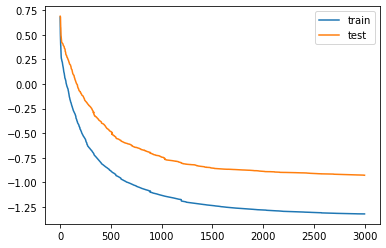

In [102]:
# plot learning curves
from matplotlib import pyplot
pyplot.plot(results['validation_0']['logloss'], label='train')
pyplot.plot(results['validation_1']['logloss'], label='test')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [103]:
#result
y_pred = model.predict(data_test)

In [104]:
pred_df = pd.DataFrame(y_pred,columns=['item_cnt_month'])
pred_df.to_csv('xgboost_2_0.001.csv')

### LSTM

In [ ]:
# importing libraries required for our model
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
dataset = original_24
data_test = test_24

In [ ]:

# X we will keep all columns execpt the last one 
X_train_n = np.expand_dims(dataset.values[:,:-1],axis = 2)
# the last column is our label
y_train_n = dataset.values[:,-1:]

# for test we keep all the columns execpt the first one
X_test_n = np.expand_dims(data_test.values[:,1:],axis = 2)

# lets have a look on the shape 
print(X_train_n.shape,y_train_n.shape,X_test_n.shape)

In [ ]:
# DEFINE our model 
model_LSTM = Sequential()
model_LSTM.add(LSTM(units =23,input_shape = (X_train_n.shape[1], X_train_n.shape[2])))
# sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_LSTM.add(Dropout(0.2))
#output layer
model_LSTM.add(Dense(1))
model_LSTM.compile(loss = 'mse',optimizer = 'adam', metrics = ['mean_squared_error'])
model_LSTM.summary()

In [ ]:
history = model_LSTM.fit(X_train_n, y_train_n,batch_size=1000,epochs=100, validation_split=0.33)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

In [ ]:
test_pred = model_LSTM.predict(X_test_n)

In [ ]:
pred_df = pd.DataFrame(test_pred,columns=['item_cnt_month'])
pred_df.to_csv('lstm_11month_100_0.01_24month_ewma.csv')